# Modélisation

In [1]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Load configuration
sys.path.append('../')

from utils import RANDOM_STATE, TEST_SIZE

In [2]:
# Load the data

df = pd.read_csv('../data/train_data.csv')
df.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [3]:
y = df.pop('Exited')
X = df.copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"The X_train set contains: {X_train.shape} elements")
print(f"The y_train set contains: {y_train.shape} elements")
print(f"The X_test set contains: {X_test.shape} elements")
print(f"The y_test set contains: {y_test.shape} elements")

The X_train set contains: (114863, 13) elements
The y_train set contains: (114863,) elements
The X_test set contains: (28716, 13) elements
The y_test set contains: (28716,) elements


## Pipeline

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(transform_output = "pandas")


In [28]:
from sklearn.pipeline import Pipeline


def create_pipeline(model):
    numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
    catagorical_features = ['Geography', 'NumOfProducts', 'Gender']

    numerical_transformer = ColumnTransformer(
        transformers=[
            ('Scaler', MinMaxScaler(), numerical_features)
        ],
        verbose_feature_names_out=False
    )

    numerical_transformer = make_pipeline(numerical_transformer, PolynomialFeatures(degree=3, include_bias=False), SelectKBest(f_classif, k=5))

    categorical_transformer = ColumnTransformer(
        transformers=[
            ('Encoder', OneHotEncoder(drop='first', sparse_output=False), catagorical_features),
        ],
        verbose_feature_names_out=False
    )

    pipeline = make_union(numerical_transformer, categorical_transformer)
    pipeline = Pipeline(steps=[('processor', pipeline), ('classifier', model)])
    return pipeline

In [6]:
from sklearn.model_selection import cross_val_score, validation_curve

In [30]:
pipeline = create_pipeline(KNeighborsClassifier(n_neighbors=6))
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Moyenne des scores de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [0.51740286 0.52179438 0.51404386 0.51368904 0.50555987]
Moyenne des scores de validation croisée : 0.514498001601932


In [10]:
from tqdm import tqdm

k_scores = {}
for k in tqdm(range(1, 50)):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = create_pipeline(model)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1")
    k_scores[k] = cv_scores.mean()

100%|██████████| 49/49 [06:32<00:00,  8.02s/it]


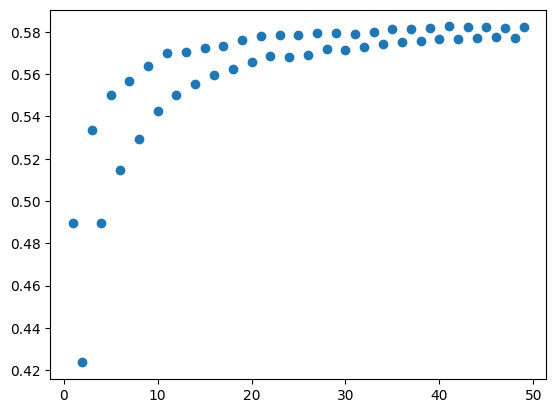

In [11]:
from matplotlib import pyplot as plt


plt.scatter(k_scores.keys(), k_scores.values())

In [31]:
model = create_pipeline(KNeighborsClassifier())
train_scores, validation_scores = validation_curve(estimator=model,
                                                    X=X_train,
                                                    y=y_train,
                                                    cv=10,
                                                    param_name="classifier__n_neighbors",
                                                    param_range=range(1, 10),
                                                    scoring="f1"
)

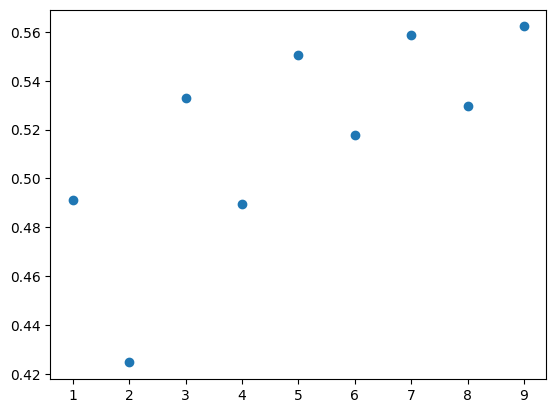

In [35]:
mean_scores = validation_scores.mean(axis=1)

plt.scatter(range(1, 10), mean_scores)

In [13]:
pipeline = create_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Moyenne des scores de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [0.55688146 0.55885688 0.54225595 0.54717627 0.53932067]
Moyenne des scores de validation croisée : 0.5488982469696554


In [14]:
k_scores = {}
for k in tqdm(range(1, 100, 5)):
    model = RandomForestClassifier(n_estimators=k)
    pipeline = create_pipeline(model)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1")
    k_scores[k] = cv_scores.mean()

100%|██████████| 20/20 [07:22<00:00, 22.14s/it]


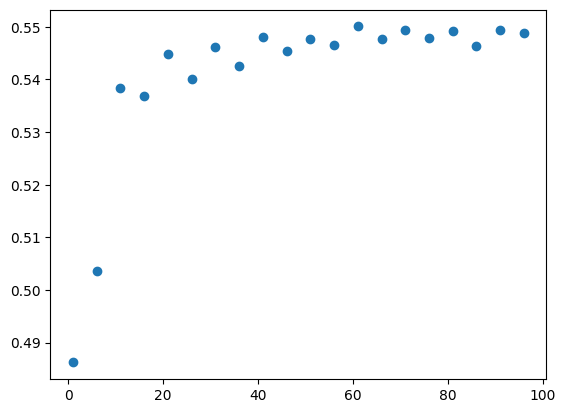

In [15]:
plt.scatter(k_scores.keys(), k_scores.values())

In [37]:
# Define the parameter grid
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


param_grid = [
    {
        'classifier': [LogisticRegression(solver='liblinear')],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.1, 1.0, 10.0]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 10, 20]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    }
]

# Create GridSearchCV
grid_search = GridSearchCV(create_pipeline(LogisticRegression()),
                           param_grid,
                           scoring='f1',
                           cv=3,  # Adjust cross-validation folds as needed
                           verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l1; total time=   1.1s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l1; total time=   1.0s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l1; total time=   1.1s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l2; total time=   0.2s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l2; total time=   0.2s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=0.1, classifier__penalty=l2; total time=   0.2s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=1.0, classifier__penalty=l1; total time=   1.6s
[CV] END classifier=LogisticRegression(solver='liblinear'), classifier__C=1.0, class

In [ ]:
# Évaluation du modèle sur le jeu de test
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")

Test set score: 0.8478548544365511


In [39]:
# On entraine le modèle sur l'ensemble des données
best_model.fit(X, y)

Pipeline(steps=[('processor',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('columntransformer',
                                                                  ColumnTransformer(transformers=[('Scaler',
                                                                                                   MinMaxScaler(),
                                                                                                   ['CreditScore',
                                                                                                    'Age',
                                                                                                    'Tenure',
                                                                                                    'Balance',
                                                                                                    'EstimatedSalary'])],
                                                                                    verbose_feature_names_out=False)),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False)),
                                                                 ('selectkbest',
                                                                  SelectKBest(k=5))])),
                                                ('columntransformer',
                                                 ColumnTransformer(transformers=[('Encoder',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['Geography',
                                                                                   'NumOfProducts',
                                                                                   'Gender'])],
                                                                   verbose_feature_names_out=False))])),
                ('classifier', GradientBoostingClassifier(n_estimators=200))])

In [40]:
test_df = pd.read_csv('../data/test_data.csv')
test_df.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [ ]:
result = best_model.predict(test_df)

In [48]:
submission_df = pd.concat([test_df['ID'], pd.DataFrame(result, columns=['Exited'])], axis=1).set_index('ID')
submission_df.head()

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0


In [50]:
submission_df.to_csv('../data/submission.csv')
check_df = pd.read_csv('../data/submission.csv')
check_df.head()

,ID,Exited
0,67897,0
1,163075,0
2,134760,1
3,68707,0
4,3428,0
